# Heuristic Value Estimate




Heuristic value has been hard to model, and getting it too bad in the first place leads to difficulties for the freshman training.
The new approach aims to improve the situation by combining a simple line-counting approach for soft-value with the hard estimates of the primary detector.

The idea: count all lines of any five positions on the board, that have only white or black stones on them. Compute
$$
\text{tanh}(\text{ln}( \eta \frac{N_b}{N_w}) \cdot \lambda)
$$

With the two hyperparameters $\eta$ and $\lambda$

$\eta$ scales the original signal such that the tanh'd signal becomes meaningful. That means, we choose $\eta$ such that most values center around the origin. $\lambda$ scales the resulting signal such that it compares meaningfully to the terminal value of $ \pm 1.0$


---

In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
import numpy as np
from aegomoku.utils import expand
from aegomoku.utils import analyse_board
from aegomoku.policies.heuristic_policy import HeuristicPolicy
from aegomoku.gomoku_board import GomokuBoard

In [140]:
BOARD_SIZE = 19

In [153]:
stones = "J10"

/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


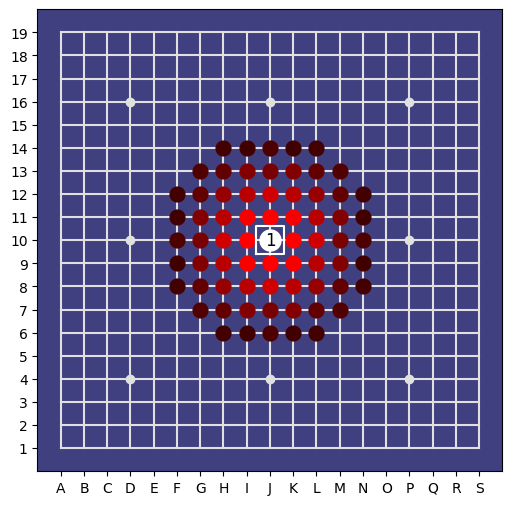

In [154]:
policy = HeuristicPolicy(BOARD_SIZE)
analyse_board(BOARD_SIZE, stones, policy)

In [155]:
CURRENT = 0
OTHER = 1
CHANNELS = [
    CURRENT, OTHER
]

RAW_PATTERNS = [
        [[-5, -5, -5, -5, -5,  1,  1,  1,  1],
         [ 0,  0,  0,  0, -5, -5, -5, -5, -5]],

        [[-5, -5, -5,  1, -5,  1,  1,  1,  0],
         [ 0,  0,  0, -5, -5, -5, -5, -5,  0]],

        [[-5, -5,  1,  1, -5,  1,  1,  0,  0],
         [ 0,  0, -5, -5, -5, -5, -5,  0,  0]],

        [[-5,  1,  1,  1, -5,  1,  0,  0,  0],
         [ 0, -5, -5, -5, -5, -5,  0,  0,  0]],

        [[ 1,  1,  1,  1, -5,  0,  0,  0,  0],
         [-5, -5, -5, -5, -5,  0,  0,  0,  0]]
]

In [156]:
from aegomoku.policies.radial import all_3xnxn


def select_patterns(channel: int = None):
    channels = [channel] if channel is not None else [0, 1]

    patterns = [
        [[offense, defense, defense]]
        if channel == CURRENT
        else [[defense, offense, defense]]
        for offense, defense in RAW_PATTERNS
        for channel in channels
    ]

    return patterns


def assemble_filters():
    """
    Considering the boundary stones just as good a defense as one of the opponent's stone.
    Boundary stones are placed on the periphery of the 3rd channel
    """
    patterns = select_patterns()
    stacked = np.stack([
        all_3xnxn(pattern[0])
        for pattern in patterns], axis=3)
    reshaped = np.reshape(stacked, (9, 9, 3, -1))

    return reshaped


In [157]:
patterns = select_patterns()
stacked = np.stack([
    all_3xnxn(pattern[0])
    for pattern in patterns], axis=3)
reshaped = np.reshape(stacked, (9, 9, 3, -1))


In [158]:
reshaped.shape

(9, 9, 3, 40)

In [159]:
import tensorflow as tf

filters = assemble_filters()
n_filters = filters.shape[-1]
n_filters

40

In [160]:
detector = tf.keras.layers.Conv2D(
    name="heuristic_value",
    filters=n_filters, kernel_size=(9, 9),
    kernel_initializer=tf.constant_initializer(filters),
    bias_initializer=tf.constant_initializer(0),
    activation=tf.nn.relu,
    padding='same',
    trainable=False)

In [161]:
board = GomokuBoard(BOARD_SIZE, stones=stones)
board.plot()

                                                                 
19    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
18    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
17    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
16    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
10    .  .  .  .  .  .  .  .  . [X] .  .  .  .  .  .  .  .  .    
 9    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 8    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 7    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 6    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 5    .  .

In [162]:
inputs = expand(board)
inputs.shape

(1, 21, 21, 3)

In [163]:
res = detector(expand(board))
res = np.squeeze(res)
res.shape

(21, 21, 40)

In [164]:
print(np.sum(res, axis=2))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 3. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 2. 3. 4. 0. 4. 3. 2. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 3. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

As expected, for a single stone on the board, we count 4 possible lines right next to the stone, and one less for each increasing distance.